### Table of Contents

* [1.0 Purpose](#1.0)
    * [1.1 Imports](#1.1)
    * [1.2 Load the data](#1.2)
    * [1.3 Inspect the data](#1.3)
* [2.1 Proportion of classes](#2.1)
    * [2.2 Dummy encoding](#2.2)
* [3.1 Split dataframe into features and target](#3.1)
    * [3.2 Preliminary modeling](#3.2)
    * [3.3 Preliminary model confusion matrix and classification report](#3.3)
* [4.0 Logistic regression model](#4.0)    
    * [4.1 Tuning hyperparameters using a pipeline and GridSearchCV](#4.1)
    * [4.2 Build a function to run GridSearchCV](#4.2)
    * [4.3 Build a function to exclude highly correlated features](#4.3)
    * [4.4 Recall results with "hold out" features to loop through](#4.4)
    * [4.5 Individual model Recall results with excluded "hold out" features](#4.5)

##### 1.0 Purpose<a id='1.0'></a>

In the previous notebook, we completed exploratory data analysis. The data was visualized in terms of correlations, both between features and targets, and between features and other features.

Now, in this notebook, we are in the preprocessing and training phase of this Capstone 2 project. We will be putting together different models for the training/testing process, then checking for accuracy.


##### 1.1 Imports<a id='1.1'></a>

In [36]:
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

##### 1.2 Load data<a id='1.2'></a>

In [37]:
path = r'C:\Users\Joseph Shire\Documents\Springboard Python Data Science\Python Scripts\springboard\Capstone2\Fetal health idea'
main_file = r'\ctg_final.csv'
df = pd.read_csv(path+main_file)
fc = r'\ctg_corr.csv'
fcorr = pd.read_csv(path+fc)
tc = r'\ctg_corr_NSP.csv'
tcorr = pd.read_csv(path+tc)

print('The main data have ', df.shape[0], ' rows and ', df.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df.columns)))

The main data have  2126  rows and  22  columns

column names: 

LB
AC
FM
UC
ASTV
MSTV
ALTV
MLTV
DL
DS
DP
Width
Min
Max
Nmax
Nzeros
Mode
Mean
Median
Variance
Tendency
NSP


Look at the correlation dataframes

In [38]:
tcorr.head(10)

,var_1,var_2,correlation,abs_corr,corr_level
0,DP,NSP_3.0,0.580253,0.580253,MID
1,ASTV,NSP_1.0,-0.493391,0.493391,LOW
2,ALTV,NSP_1.0,-0.489400,0.489400,LOW
3,NSP_3.0,Mode,-0.419051,0.419051,LOW
4,ALTV,NSP_2.0,0.418659,0.418659,LOW
5,NSP_3.0,Mean,-0.416886,0.416886,LOW
6,Median,NSP_3.0,-0.384857,0.384857,LOW
7,AC,NSP_1.0,0.369470,0.369470,LOW
8,NSP_2.0,ASTV,0.348213,0.348213,LOW
9,LB,NSP_2.0,0.341922,0.341922,LOW


In [39]:
fcorr.head(10)

,var_1,var_2,correlation,abs_corr,corr_level
0,Median,Mean,0.948251,0.948251,HIGH
1,Mode,Median,0.933399,0.933399,HIGH
2,Min,Width,-0.898519,0.898519,HIGH
3,Mode,Mean,0.893412,0.893412,HIGH
4,LB,Median,0.789246,0.789246,HIGH
5,Width,Nmax,0.747071,0.747071,HIGH
6,Mean,LB,0.723121,0.723121,HIGH
7,Mode,LB,0.708993,0.708993,HIGH
8,Max,Width,0.690769,0.690769,MID
9,Min,Nmax,-0.670287,0.670287,MID


##### 2.1 Proportion of classes<a id='2.1'></a>

When building classification models, it is essential to know right away the number of samples per class, proportionally to the total number of samples.

For our fetal health data, the diagnostic categories are: Normal = N, Suspect = S, Pathological = P.

In [40]:
nsp = ['N','S','P']
df['NSP'] = df['NSP'].replace([1.0,2.0,3.0],nsp)

In [41]:
class_counts_nsp = df['NSP'].value_counts()
class_p_nsp = pd.Series([(x / df.shape[0]) * 100.00 for x in class_counts_nsp])

Visualize Proportionality

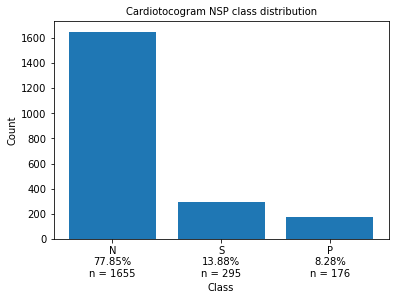

In [42]:
fig, ax = plt.subplots()
ax.bar(class_counts_nsp.index, class_counts_nsp)
ax.set_xticks([0,1,2])

a=ax.get_xticks().tolist()
for i in a:    
    a[i] = nsp[i]+'\n' + class_p_nsp.round(2).astype(str)[i] + '%'+'\n' +'n = '+class_counts_nsp.astype(str)[i]
ax.set_xticklabels(a)
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_title('Cardiotocogram NSP class distribution',
              fontsize = 10)
plt.show()

Important decision on removing a class

Due to the nature of health sciences having the main purpose of supporting well-being of patients, we have determined to eliminate the "Suspect" class from our initial analysis. At-risk fetuses are either in health danger (Pathological class), or not (Normal class). In the next notebook, we will endeavour to reclassify these 295 patients into one of the binary classes of Normal or Pathological, and inspect the results through graphical visualizations.

Having made this determination, we will thus remove "S" class datapoints from our data during this preprocessing step.

In [43]:
df2 = df[df['NSP'] != 'S']
df2['NSP'].value_counts()

N    1655
P     176
Name: NSP, dtype: int64

In [44]:
class_counts_np = df2['NSP'].value_counts()
class_p_np = pd.Series([(x / df2.shape[0]) * 100.00 for x in class_counts_np])

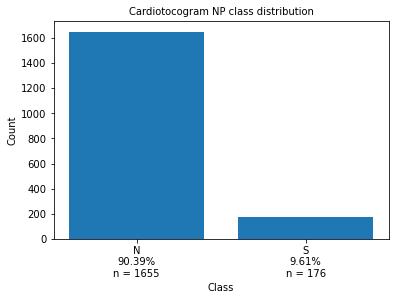

In [45]:
fig, ax = plt.subplots()
ax.bar(class_counts_np.index, class_counts_np)
ax.set_xticks([0,1])

a=ax.get_xticks().tolist()
for i in a:    
    a[i] = nsp[i]+'\n' + class_p_np.round(2).astype(str)[i] + '%'+'\n' +'n = '+class_counts_np.astype(str)[i]
ax.set_xticklabels(a)
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_title('Cardiotocogram NP class distribution',
              fontsize = 10)
plt.show()

##### 2.2 Dummy encode only categorical feature<a id='2.2'></a>

The feature "Tendency" is a categorical variable, and will need dummies applied

In [46]:
df2['Tendency'].value_counts()

 0.0    978
 1.0    703
-1.0    150
Name: Tendency, dtype: int64

According to documentaiton, 'Tendency' is histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric

In [47]:
dfd = pd.get_dummies(df2, columns = ['Tendency'], drop_first=True)
dfd

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency_0.0,Tendency_1.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,N,1,0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,N,1,0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,N,0,1
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,N,0,1
5,134.0,1.0,0.0,10.0,26.0,5.9,0.0,0.0,9.0,0.0,...,200.0,5.0,3.0,76.0,107.0,107.0,170.0,P,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,140.0,0.0,0.0,6.0,79.0,0.3,20.0,8.5,0.0,0.0,...,150.0,1.0,0.0,144.0,143.0,145.0,1.0,N,0,1
2118,140.0,0.0,0.0,7.0,79.0,0.5,26.0,7.0,1.0,0.0,...,150.0,1.0,0.0,145.0,142.0,145.0,2.0,N,0,1
2119,140.0,0.0,0.0,6.0,79.0,0.6,27.0,6.4,1.0,0.0,...,150.0,1.0,0.0,144.0,141.0,145.0,1.0,N,0,1
2120,140.0,0.0,0.0,4.0,77.0,0.7,17.0,6.0,1.0,0.0,...,155.0,2.0,0.0,145.0,143.0,145.0,2.0,N,1,0


##### 3.1 Split dataframe into features and target<a id='3.1'></a>

Setting our features as the X variable, and targets as the y variable for use in our modeling.

In [48]:
X = dfd.drop(columns = ['NSP'])

In [49]:
y = dfd['NSP']

In [50]:
print(X.head(),y.head())

      LB   AC   FM    UC  ASTV  MSTV  ALTV  MLTV   DL   DS  ...   Min    Max  \
1  132.0  4.0  0.0   4.0  17.0   2.1   0.0  10.4  2.0  0.0  ...  68.0  198.0   
2  133.0  2.0  0.0   5.0  16.0   2.1   0.0  13.4  2.0  0.0  ...  68.0  198.0   
3  134.0  2.0  0.0   6.0  16.0   2.4   0.0  23.0  2.0  0.0  ...  53.0  170.0   
4  132.0  4.0  0.0   5.0  16.0   2.4   0.0  19.9  0.0  0.0  ...  53.0  170.0   
5  134.0  1.0  0.0  10.0  26.0   5.9   0.0   0.0  9.0  0.0  ...  50.0  200.0   

   Nmax  Nzeros   Mode   Mean  Median  Variance  Tendency_0.0  Tendency_1.0  
1   6.0     1.0  141.0  136.0   140.0      12.0             1             0  
2   5.0     1.0  141.0  135.0   138.0      13.0             1             0  
3  11.0     0.0  137.0  134.0   137.0      13.0             0             1  
4   9.0     0.0  137.0  136.0   138.0      11.0             0             1  
5   5.0     3.0   76.0  107.0   107.0     170.0             1             0  

[5 rows x 22 columns] 1    N
2    N
3    N
4    N


In [51]:
y.value_counts()

N    1655
P     176
Name: NSP, dtype: int64

##### 3.2 Preliminary modeling<a id='3.2'></a>

Start by training a single model on a single set of parameters, to see what non-tuned results might look like

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, stratify = y)

In [53]:
y_train.value_counts()

N    1241
P     132
Name: NSP, dtype: int64

In [54]:
y_test.value_counts()

N    414
P     44
Name: NSP, dtype: int64

Scale the data

In [55]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),columns=X_test.columns)

We will use Logistic Regression cross validation, with built-in stratified k-folds for cross-validation, the solver 'saga', penalty of 'l2', maximum iterations set to 5000, and regularization (C) at intervals from 0.1 to 100.

We will focus on recall for a scoring metric, due to class imbalance and the importance of reducing false negatives. The business interest lies in detecting pathological health conditions, so ensuring that Class P 'positives' are detected accurately is most important.

In [56]:
lrcv = LogisticRegressionCV(solver = 'saga', penalty = 'l2', 
                            max_iter = 5000, Cs=[0.1,1,10,100], 
                            cv = StratifiedKFold(n_splits=5, shuffle=True),
                           scoring='recall')

We fit the training data to the model

In [57]:
lrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.1, 1, 10, 100],
                     cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                     max_iter=5000, scoring='recall', solver='saga')

In [58]:
lrcv.scores_

{'P': array([[0.61538462, 0.69230769, 0.80769231, 0.84615385],
        [0.81481481, 0.88888889, 0.88888889, 0.88888889],
        [0.81481481, 0.96296296, 1.        , 0.96296296],
        [0.80769231, 0.88461538, 0.92307692, 0.92307692],
        [0.88461538, 0.96153846, 0.96153846, 0.96153846]])}

In [59]:
Cs = [0.1, 1, 10, 100]
j = 0

for i in lrcv.scores_['P'].T:
    print("CV mean for C of ",Cs[j], " = ",i.mean(axis=0))
    j +=1

CV mean for C of  0.1  =  0.7874643874643875
CV mean for C of  1  =  0.8780626780626781
CV mean for C of  10  =  0.9162393162393163
CV mean for C of  100  =  0.9165242165242166


There does not appear to be data leakage or over fitting.

Now we can run Logistic Regression with set parameters to see how the training data compares to the testing data.

In [60]:
lr = LogisticRegression(solver = 'saga', penalty = 'l2', 
                            max_iter = 5000, C=100)

In [61]:
lr.fit(X_train,y_train)

LogisticRegression(C=100, max_iter=5000, solver='saga')

In [62]:
y_pred_tr = lr.predict(X_train)
y_pred = lr.predict(X_test)

Then assess recall scores for training and testing data

In [63]:
print(f'Recall on training data: ',recall_score(y_train,y_pred_tr,pos_label='P'))

Recall on training data:  0.946969696969697


In [64]:
print(f'Recall on test data: ',recall_score(y_test,y_pred,pos_label='P'))

Recall on test data:  0.9090909090909091


##### 3.3 Preliminary model confusion matrix and classification report<a id='3.3'></a>

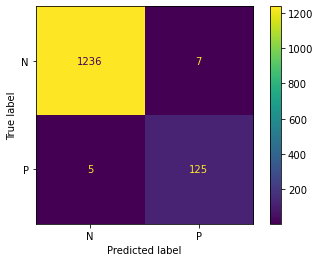

In [65]:
cm = confusion_matrix(y_pred_tr, y_train)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)


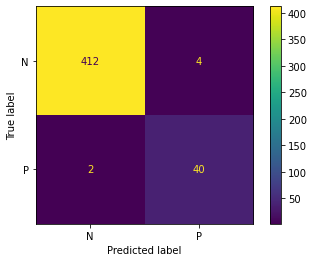

In [66]:
cm = confusion_matrix(y_pred, y_test)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
ax.set_xticks([0, 2])
ax.set_yticks([0, 2])
display_cm.plot(ax = ax)

For a closer look at the performance, a classification report is created for both training and testing data

In [67]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_tr))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.99      1.00      1.00      1241
           P       0.96      0.95      0.95       132

    accuracy                           0.99      1373
   macro avg       0.98      0.97      0.97      1373
weighted avg       0.99      0.99      0.99      1373



In [68]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.99      1.00      0.99       414
           P       0.95      0.91      0.93        44

    accuracy                           0.99       458
   macro avg       0.97      0.95      0.96       458
weighted avg       0.99      0.99      0.99       458



The model performs better than randomly guessing, but there is room for improvement. Considering our performance metric, recall, the model (as expected) performs extremely well on the training data, and less well on the test data.

The researchers who collected this data appear to have done a good job of engineering features.

##### 4.0 Conclusions<a id='4.0'></a>

As mentioned before, we will focus on recall for a scoring metric, due to class imbalance and the importance of reducing false negatives. The business interest lies in detecting pathological health conditions, so ensuring that Class P 'positives' are detected accurately is most important.

The current model with the current algorithm (Logistic Regression) produces on output where testing recall for the positive class is 91%. 

In our next notebook, Modeling, we will explore using Logistic Regression, in addition to other algorithms to build the most accurate model for our data. Other algorithms may include include Random Forest Classifier, XGBOOST Classifier, and LGBM Classifier.
My goal will be to increase performance by trying multiple models and using resampling methods.